Goal : Create a sklearn data pipeline to take the data from my matlab struct, convert it to a pandas data frame, clean and scale/standardize it. Create a sklearn estimator using psytrack to be able to use randomized search to optimize the hyperparameters of the model. Maybe also use a recursive feature elimination (https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_digits.html#sphx-glr-auto-examples-feature-selection-plot-rfe-digits-py) to determine the optimal attributes to fir the data.

In [10]:
def mat_struct_2_pd(folderpath, file):
    import pandas as pd
    import os
    from scipy.io import loadmat
    import numpy as np

    file_data = 'analyze_animal_'+file+'.mat'
    path = os.path.join(folderpath,file_data);
    mouse_mat = loadmat(path, struct_as_record = False, squeeze_me = True, mat_dtype = True)
    
    m = mouse_mat['animal']
    beh = pd.DataFrame((m.lick.T).astype(bool))
    beh.columns = ['RH', 'LH', 'RM', 'LM', 'NG']
    beh['LED'] = (m.LED).astype(bool)
    beh['Session'] = m.sessionNum
    beh['Stimulus'] = m.stimulus
    beh['Target'] = m.target 

    file_ttl = 'ttl_info_'+file+'.mat'
    ttl_path = os.path.join(folderpath, file_ttl)
    mouse_ttl = loadmat(ttl_path, struct_as_record = False, squeeze_me = True, mat_dtype = True)
    beh['Spout_1']= np.mean(mouse_ttl['trial_info'].lick[:,750:825,0],axis = 1)
    beh['Spout_2'] = np.mean(mouse_ttl['trial_info'].lick[:,750:825,1],axis = 1)
    
    file_ttl2 = 'ttl_choices_'+file+'.mat'
    ttl_path2 = os.path.join(folderpath, file_ttl2)
    mouse_ttl2 = loadmat(ttl_path2, struct_as_record = False, squeeze_me = True, mat_dtype = True)
    c = mouse_ttl2['trial_info'].choice[:,:,750:2750]
    rx = []
    ch= []
    for a in range(c.shape[0]):
        r = (np.argwhere(c[a,:,:]== 1))
    
        if r.size == 0 and m.rxnTime[a] > 0:
            rx.append(m.rxnTime[a]);
        elif r.size == 0:
            rx.append(np.nan)
            #ch.append(np.nan)
        else:
            #ch.append(r[0][0])
            rx.append(r[0][1])
    
    beh['latency'] = rx
    #beh['early'] = ch
    

    file_training = 'analyze_training_'+file+'.mat'
    training_path = os.path.join(folderpath, file_training)
    mouse_train = loadmat(training_path,struct_as_record = False, squeeze_me = True, mat_dtype = True)
    
    train = mouse_train['training']
    tdata = {'trials_opto': [train.trials_opto], 'trials_prof': [train.trials_proficient],
        'trials_expert': [train.trials_expert], 'days_opto': [train.days_opto],
        'days_prof':[train.days_proficient], 'days_expert': [train.days_expert]}
    
    t = pd.DataFrame(tdata)


    

    return beh, t


In [11]:
def clean_behavior_data(b):
    import numpy as np
    import pandas as pd

    #b2 = b.copy()
    b2 = pd.DataFrame()
    ns = np.array(np.append(1, np.diff(b['Session'])), dtype = bool)

    b2['Rightward'] = (b['RH'] | b['LM']).astype(int)
    pr = np.concatenate(([0], b2['Rightward'][:-1].values));
    pr[ns] = 0;
    b2['Previous_rightward'] = pr;

    b2['Correct'] = (b['RH'] | b['LH']).astype(int)
    pc = np.concatenate(([0], b2['Correct'][:-1].values))  
    pc[ns] = 0;
    b2['Previous_correct'] = pc;

    b2['Stimulus'] =np.log2(b['Stimulus']/8)/2
    b2['LED'] = b['LED'].astype(int);
    b2['Target'] = b['Target'].astype(int);
    b2['Session'] = b['Session'];

   
    b2['Latency'] = b['latency']/2000;
    #b2['New_session']= ns;
   
    go = (b['RH'] | b['LM'] | b['RM'] | b['LH']).values
    
    b2 = b2.iloc[go,:]
    
    return b2

In [12]:
folderpath = r'/Users/rebeccakrall/Downloads';
#folderpath = r'C:\Users\natet\Desktop\Experimental_Data\Control\c_129'
animal = 'c_129';

b,t = mat_struct_2_pd(folderpath, animal)
b2 = clean_behavior_data(b)

In [13]:
import numpy as np

inputs = dict(stim = np.expand_dims(np.array(b2['Stimulus']), axis=1),
    LED = np.expand_dims(np.array(b2['Stimulus']).astype(int), axis=1),
    previous_correct =  np.expand_dims(np.array(b2['Previous_correct']).astype(int), axis=1),
    previous_choice =  np.expand_dims(np.array(b2['Previous_rightward']).astype(int), axis=1),
    latency = np.expand_dims (np.array(b2['Previous_rightward']).astype(int), axis=1)
)   

dat = dict(
        subject = animal,
        inputs = inputs,
        correct = np.array(b2['Correct']),
        answer = np.array(b2['Target']),
        y = np.array(b2['Rightward']),
        dayLength=np.array(b2.groupby(['Session']).size()),
    )

In [98]:
import psytrack as psy

weights = {k: 1 for k in inputs}
weights['bias'] = 1

k = np.sum([weights[i] for i in weights.keys()])
hyper = {'sigInit': 2**4., 'sigma': [2**4.]*k, 'sigDay': 2**4.};
optList = ['sigma', 'sigDay'];

hyp, full_model, wMode, hess_info = psy.hyperOpt(dat, hyper, weights, optList, showOpt = 0); 
mod_e = (-2 * full_model) + (len(optList) * np.log(t))


/opt/anaconda3/lib/python3.9/site-packages/psytrack/getMAP.py:311: RuntimeWarning: overflow encountered in exp
  pR = 1 / (1 + np.exp(-gw))


NameError: name 'model_evd' is not defined

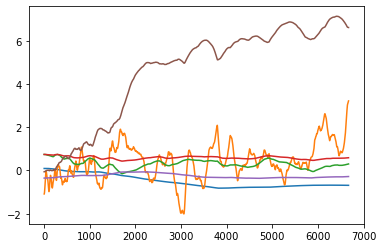

['LED', 'bias', 'latency', 'previous_choice', 'previous_correct', 'stim']

In [103]:
import matplotlib_inline 
import matplotlib.pyplot as plt

plt.plot(wMode.T);
plt.show()
sorted(weights.keys())

In [8]:
import os
import re
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.special import expit
import numpy as np
import pandas as pd

import psytrack_learning as psy
from psytrack_learning.getMAP import getMAP
from psytrack_learning.helper.helperFunctions import update_hyper, hyper_to_list
from psytrack_learning.helper.jacHessCheck import compHess, compHess_nolog
from psytrack_learning.helper.invBlkTriDiag import getCredibleInterval
from psytrack_learning.hyperparameter_optimization import evd_lossfun
from psytrack_learning.learning_rules import RewardMax, PredictMax, REINFORCE, REINFORCE_base
from psytrack_learning.simulate_learning import reward_max, predict_max, reinforce, reinforce_base 
from psytrack_learning.simulate_learning import simulate_learning

In [9]:

rec_learning_rule = REINFORCE
weights = {'bias' : 1, 'stim' :1, 'LED': 1}
K = np.sum([weights[i] for i in weights.keys()])
hyper_guess = {
    'alpha': [2**-6] * K,
    'sigma': [2**-4] * K,
    'sigInit': [2**4] * K,
    'sigDay': None,
}

# Optimizing for both sigma and alpha simultaneously
optList = ['sigma', 'alpha']


# List of extra arguments used by evd_lossfun in optimization of evidence
args = {"optList": optList, "dat": dat, "K": K, "learning_rule": REINFORCE,
        "hyper": hyper_guess, "weights": weights, "update_w": True, "wMode": None,
        "tol": 1e-6, "showOpt": True}

# Optimization, can also use Nelder-Mead but COBYLA is fastest and pretty reliable
res = minimize(evd_lossfun, hyper_to_list(hyper_guess, optList, K), args=args, method='COBYLA')
print("Evidence:", -res.fun, "  ", optList, ": ", res.x)

opt_hyper = update_hyper(res.x, optList, hyper_guess, K)
wMode, Hess, logEvd, other = getMAP(dat, opt_hyper, weights, W0=None,
                                    learning_rule=rec_learning_rule, showOpt=0, tol=1e-12)
# Recover error bars for weights
W_std = getCredibleInterval(Hess, K)
wMode = wMode.reshape((K, -1), order="C")

rec_dat = {"args": args, 'res': res, 'opt_hyper': opt_hyper, "W_std": W_std, "wMode": wMode}

    [-4. -4. -4. -6. -6. -6.] 1 2246.484 
    [-3. -4. -4. -6. -6. -6.] 2 2257.863 
    [-4. -3. -4. -6. -6. -6.] 3 2224.877 
    [-4. -3. -3. -6. -6. -6.] 4 2234.314 
    [-4. -3. -4. -5. -6. -6.] 5 2226.082 
    [-4. -3. -4. -6. -5. -6.] 6 2221.859 
    [-4. -3. -4. -6. -5. -5.] 7 2223.082 
    [-4.431 -2.182 -4.357 -6.046 -4.886 -6.046] 8 2217.209 
    [-3.577 -1.71  -4.563 -6.072 -4.82  -6.073] 9 2234.874 
    [-5.242 -2.565 -4.772 -6.099 -4.753 -6.1  ] 10 2212.007 
    [-5.894 -2.408 -4.04  -6.141 -4.647 -6.143] 11 2215.595 
    [-5.207 -2.573 -4.769 -6.597 -4.753 -6.1  ] 12 2210.878 
    [-5.444 -2.501 -5.621 -6.876 -4.413 -6.238] 13 2210.531 
    [-5.568 -2.47  -5.756 -6.923 -4.875 -6.258] 14 2213.533 
    [-5.472 -2.448 -5.644 -6.879 -4.406 -5.996] 15 2210.711 
    [-5.384 -2.966 -5.627 -6.929 -4.27  -6.157] 16 2211.98 
    [-5.214 -2.481 -5.706 -6.861 -4.451 -6.223] 17 2211.364 
    [-5.512 -2.247 -5.412 -7.003 -4.078 -6.332] 18 2209.62 
    [-5.626 -2.182 -5.451 -6.559 -3.9  